In [1]:
import pandas as pd

**Handle collections import warnings**

In [2]:
try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable

**Suppress other annoying warnings**

In [3]:
import logging
import warnings

logging.basicConfig( format='%(asctime)s : %(levelname)s : %(message)s' , 
    level=logging.ERROR )

warnings.filterwarnings( "ignore" , category=DeprecationWarning )
warnings.filterwarnings( action='ignore', category=UserWarning, module='gensim' )
warnings.simplefilter( action='ignore', category=FutureWarning )

**Display progress bars**

In [4]:
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

# Read Article Data

In [5]:
data = pd.read_csv( 'data/bbc-articles.csv' )

In [6]:
data.shape

(309, 2)

In [7]:
data = data.dropna().reset_index( drop=True )

In [8]:
data.shape

(308, 2)

# Clean Data

**Count the number of articles in each language**

In [9]:
from langdetect import detect


In [10]:
data['language'] = data.articles.progress_map( detect )

In [11]:
data.language.value_counts()

en    257
fa      9
fr      7
id      5
uk      4
hi      4
ru      4
ar      4
vi      4
sw      3
es      2
pt      2
tr      2
de      1
Name: language, dtype: int64

#### Keep only the English language articles

In [12]:
data = data.loc[data.language=='en']

**Split articles into sentences.**

In [13]:
from nltk.tokenize import sent_tokenize

In [14]:
data['sentences'] = data.articles.progress_map( sent_tokenize )


**Display first three sentences of first article.**

In [15]:
data['sentences'].head(1).tolist()[0][:3] 

['Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list\r\n\r\nRussian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.',
 'The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election.',
 'However, the US stressed those named were not subject to new sanctions.']

**Tokenize words in each sentence.**

In [16]:
from nltk.tokenize import word_tokenize

In [17]:
data['tokens_sentences'] = data['sentences'].progress_map( lambda sentences: [ word_tokenize( sentence ) for sentence in sentences ] )
print( data['tokens_sentences'].head(1).tolist()[0][:3] )


[['Image', 'copyright', 'PA/EPA', 'Image', 'caption', 'Oligarch', 'Roman', 'Abramovich', '(', 'l', ')', 'and', 'PM', 'Dmitry', 'Medvedev', 'are', 'on', 'the', 'list', 'Russian', 'President', 'Vladimir', 'Putin', 'says', 'a', 'list', 'of', 'officials', 'and', 'businessmen', 'close', 'to', 'the', 'Kremlin', 'published', 'by', 'the', 'US', 'has', 'in', 'effect', 'targeted', 'all', 'Russian', 'people', '.'], ['The', 'list', 'names', '210', 'top', 'Russians', 'as', 'part', 'of', 'a', 'sanctions', 'law', 'aimed', 'at', 'punishing', 'Moscow', 'for', 'meddling', 'in', 'the', 'US', 'election', '.'], ['However', ',', 'the', 'US', 'stressed', 'those', 'named', 'were', 'not', 'subject', 'to', 'new', 'sanctions', '.']]


#### Lemmatize words (with part of speech tagging)

In [18]:
from nltk import pos_tag

In [19]:
data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
print(data['POS_tokens'].head(1).tolist()[0][:3])


[[('Image', 'NN'), ('copyright', 'NN'), ('PA/EPA', 'NNP'), ('Image', 'NNP'), ('caption', 'NN'), ('Oligarch', 'NNP'), ('Roman', 'NNP'), ('Abramovich', 'NNP'), ('(', '('), ('l', 'NN'), (')', ')'), ('and', 'CC'), ('PM', 'NNP'), ('Dmitry', 'NNP'), ('Medvedev', 'NNP'), ('are', 'VBP'), ('on', 'IN'), ('the', 'DT'), ('list', 'NN'), ('Russian', 'NNP'), ('President', 'NNP'), ('Vladimir', 'NNP'), ('Putin', 'NNP'), ('says', 'VBZ'), ('a', 'DT'), ('list', 'NN'), ('of', 'IN'), ('officials', 'NNS'), ('and', 'CC'), ('businessmen', 'NNS'), ('close', 'RB'), ('to', 'TO'), ('the', 'DT'), ('Kremlin', 'NNP'), ('published', 'VBN'), ('by', 'IN'), ('the', 'DT'), ('US', 'NNP'), ('has', 'VBZ'), ('in', 'IN'), ('effect', 'NN'), ('targeted', 'VBN'), ('all', 'DT'), ('Russian', 'JJ'), ('people', 'NNS'), ('.', '.')], [('The', 'DT'), ('list', 'NN'), ('names', 'RB'), ('210', 'CD'), ('top', 'JJ'), ('Russians', 'NNPS'), ('as', 'IN'), ('part', 'NN'), ('of', 'IN'), ('a', 'DT'), ('sanctions', 'NNS'), ('law', 'NN'), ('aimed',

**Create a lemmatizer**

In [20]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

**Lemmatize each word**

In [21]:
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

In [22]:
data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['Image',
  'copyright',
  'PA/EPA',
  'Image',
  'caption',
  'Oligarch',
  'Roman',
  'Abramovich',
  '(',
  'l',
  ')',
  'and',
  'PM',
  'Dmitry',
  'Medvedev',
  'be',
  'on',
  'the',
  'list',
  'Russian',
  'President',
  'Vladimir',
  'Putin',
  'say',
  'a',
  'list',
  'of',
  'official',
  'and',
  'businessmen',
  'close',
  'to',
  'the',
  'Kremlin',
  'publish',
  'by',
  'the',
  'US',
  'have',
  'in',
  'effect',
  'target',
  'all',
  'Russian',
  'people',
  '.'],
 ['The',
  'list',
  'names',
  '210',
  'top',
  'Russians',
  'as',
  'part',
  'of',
  'a',
  'sanction',
  'law',
  'aim',
  'at',
  'punish',
  'Moscow',
  'for',
  'meddle',
  'in',
  'the',
  'US',
  'election',
  '.'],
 ['However',
  ',',
  'the',
  'US',
  'stress',
  'those',
  'name',
  'be',
  'not',
  'subject',
  'to',
  'new',
  'sanction',
  '.']]

#### Regroup tokens and remove stop words

In [23]:
from nltk.corpus import stopwords
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = stopwords.words('English') + stopwords_verbs + stopwords_other

In [24]:
from itertools import chain 

**Flatten list of sentences of tokens to list of tokens**

In [25]:
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [26]:
data['tokens'].head(1).tolist()[0][:30]

['oligarch',
 'roman',
 'abramovich',
 'pm',
 'dmitry',
 'medvedev',
 'list',
 'russian',
 'president',
 'vladimir',
 'putin',
 'list',
 'official',
 'businessmen',
 'close',
 'kremlin',
 'publish',
 'us',
 'effect',
 'target',
 'russian',
 'people',
 'list',
 'names',
 'top',
 'russians',
 'part',
 'sanction',
 'law',
 'aim']

# Latent Dirichlet Analysis (LDA)

## Data preparation

#### Prepare bigrams and trigrams

In [27]:
from gensim.models.phrases import Phraser
from gensim.models.phrases import Phrases

In [28]:
tokens = data['tokens'].tolist()
bigram_model = Phrases( tokens )
trigram_model = Phrases( bigram_model[tokens], min_count=1 )
tokens = list( trigram_model[bigram_model[tokens]] )

#### Prepare objects for LDA gensim implementation

In [29]:
from gensim import corpora

In [30]:
dictionary_LDA = corpora.Dictionary( tokens )
dictionary_LDA.filter_extremes( no_below=3 )
corpus = [dictionary_LDA.doc2bow( tok ) for tok in tokens]

## Run LDA

In [31]:
from gensim import models
import numpy as np

In [32]:
np.random.seed( 32767 ) # Set pseudorandom number generate seed.

num_topics = 20 # We'll start by extracting 20 topics.

%time lda_model = models.LdaModel( corpus, num_topics=num_topics, \
                                   id2word=dictionary_LDA, \
                                   passes=10, \
                                   random_state=32767, \
                                   alpha=[0.01] * num_topics, \
                                   eta=[0.01] * len( dictionary_LDA.keys() ) )

Wall time: 2.19 s


## Overview of LDA results

**Compute perplexity, a measure of how good the model is.**  
**The lower the perplexity value the better.**  


In [33]:
print( 'Perplexity: ', lda_model.log_perplexity( corpus ) )


Perplexity:  -8.564669161939024


**Compute Coherence Score.**  
**The higher the coherence value the better.**  

In [34]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(\
    model = lda_model, corpus=corpus, texts=tokens, dictionary=dictionary_LDA, coherence = 'c_v' )

coherence_lda = coherence_model_lda.get_coherence()

print( '\nCoherence Score (c_v): ' , coherence_lda )



Coherence Score (c_v):  0.31181059068285205


#### Look at topics

In [35]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.018*"us" + 0.011*"company" + 0.007*"could" + 0.007*"data" + 0.006*"product" + 0.006*"show" + 0.006*"base" + 0.006*"work" + 0.005*"much" + 0.005*"people" + 0.005*"user" + 0.005*"amazon" + 0.005*"call" + 0.005*"firm" + 0.005*"time" + 0.005*"news" + 0.005*"uk" + 0.005*"well" + 0.005*"find" + 0.004*"year"

1: 0.016*"design" + 0.014*"images" + 0.011*"instagram" + 0.010*"people" + 0.008*"designer" + 0.008*"business" + 0.008*"include" + 0.008*"video" + 0.007*"logo" + 0.007*"perform" + 0.006*"grammys" + 0.006*"couple" + 0.006*"write" + 0.005*"strong" + 0.005*"woman" + 0.005*"add" + 0.005*"night" + 0.005*"artist" + 0.005*"us" + 0.005*"look"

2: 0.007*"show" + 0.007*"first" + 0.007*"people" + 0.007*"us" + 0.006*"city" + 0.006*"back" + 0.006*"time" + 0.006*"work" + 0.006*"year" + 0.005*"think" + 0.005*"way" + 0.004*"day" + 0.004*"even" + 0.004*"play" + 0.004*"feel" + 0.004*"still" + 0.004*"family" + 0.004*"house" + 0.004*"president" + 0.004*"set"

3: 0.012*"people" + 0.011*"tell" + 0.009*"be

#### Allocate topics to documents

In [36]:
print( data.articles.loc[0][:500] )

Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list

Russian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.

The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election.

However, the US stressed those named were not subject to new sanctions.

Mr Putin said the list was an unfr


In [37]:
lda_model[corpus[0]]

[(12, 0.3720255), (14, 0.6263701)]

#### Predict topics for unseen documents

In [38]:
document = '''Eric Tucker, a 35-year-old co-founder of a marketing company in Austin, Tex., had just about 40 Twitter followers. But his recent tweet about paid protesters being bused to demonstrations against President-elect Donald J. Trump fueled a nationwide conspiracy theory — one that Mr. Trump joined in promoting. 

Mr. Tucker's post was shared at least 16,000 times on Twitter and more than 350,000 times on Facebook. The problem is that Mr. Tucker got it wrong. There were no such buses packed with paid protesters.

But that didn't matter.

While some fake news is produced purposefully by teenagers in the Balkans or entrepreneurs in the United States seeking to make money from advertising, false information can also arise from misinformed social media posts by regular people that are seized on and spread through a hyperpartisan blogosphere.

Here, The New York Times deconstructs how Mr. Tucker’s now-deleted declaration on Twitter the night after the election turned into a fake-news phenomenon. It is an example of how, in an ever-connected world where speed often takes precedence over truth, an observation by a private citizen can quickly become a talking point, even as it is being proved false.'''
tokens = word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,0,0.21,"0.018*""us"" + 0.011*""company"" + 0.007*""could"" +..."
1,3,0.34,"0.012*""people"" + 0.011*""tell"" + 0.009*""benefit..."
2,11,0.29,"0.013*""light"" + 0.011*""water"" + 0.009*""wave"" +..."
3,16,0.16,"0.013*""people"" + 0.007*""police"" + 0.007*""call""..."


## Look at LDA results more closely

#### Allocate topics for all documents

In [39]:
topics = [lda_model[corpus[i]] for i in range( len(data) )]

In [40]:
def topics_document_to_dataframe( topics_document, num_topics ):
    res = pd.DataFrame( columns=range( num_topics ) )
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,NaN,NaN,NaN,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


**Create matrix of topic weights.  Documents are rows and topics are columns.**

In [41]:
document_topic = \
pd.concat( [topics_document_to_dataframe( topics_document, num_topics=num_topics ) for topics_document in topics] ) \
  .reset_index( drop=True ).fillna(0)

In [42]:
document_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.372026,0.0,0.626369,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.976827,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.998829
3,0.0,0.973608,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.999021,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


**Which documents are about topic 10?**

In [43]:
document_topic.sort_values( 10, ascending=False )[10].head(20)

79     0.999199
238    0.996945
245    0.983035
10     0.979346
250    0.963459
37     0.162877
124    0.050000
55     0.050000
123    0.050000
125    0.050000
168    0.000000
176    0.000000
169    0.000000
167    0.000000
170    0.000000
171    0.000000
166    0.000000
172    0.000000
173    0.000000
174    0.000000
Name: 10, dtype: float64

In [44]:
print( data.articles.loc[91][:1000] )

Image caption Brendan Cole was a professional dancer on Strictly Come Dancing for 13 years

Brendan Cole has announced he will not be returning to Strictly Come Dancing.

The professional dancer revealed during a TV interview on Tuesday that the decision was made by the BBC, saying he was "in shock".

"They made an editorial decision not to have me back on the show," he said on ITV's Lorraine.

A spokesman for the BBC One show thanked Cole for "being part of the show since the beginning" and contributing to its success.

'Emotional and raw'

Cole said: "I'm a little bit in shock at the moment.

"I'm quite emotional and a bit raw about it. I am very disappointed. It's an editorial decision. I will never know the ins and outs.

"I have had 15 incredible series on the show, I'm very proud of the whole show, they're a great team."

Media playback is unsupported on your device Media caption In an interview on 16 January, Brendan Cole told 5 live he wanted to return to Stri


#### Look at distribution of topics in all documents

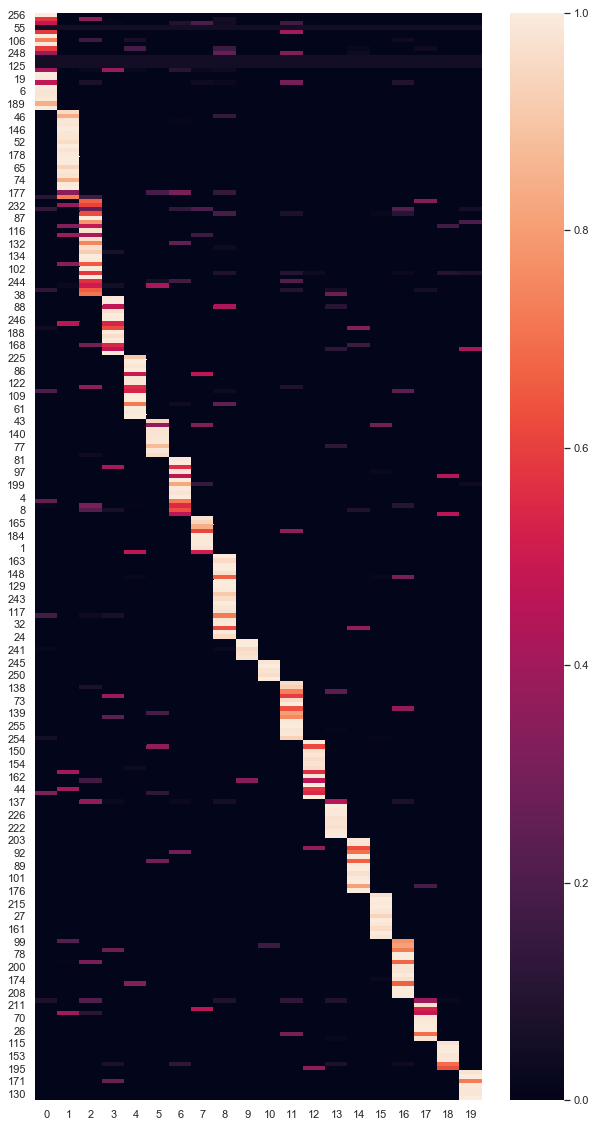

In [45]:
%matplotlib inline
import seaborn as sns; sns.set( rc={'figure.figsize':(10,20)} )
sns.heatmap( document_topic.loc[document_topic.idxmax(axis=1).sort_values().index] )

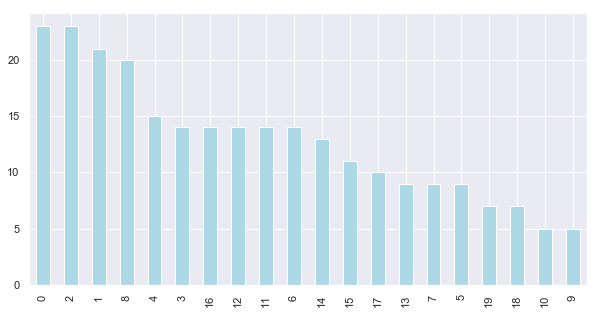

In [46]:
sns.set( rc={'figure.figsize':(10,5)} )
document_topic.idxmax( axis=1 ).value_counts().plot.bar( color='lightblue' )

#### Visualize topics

Size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus  
Red bars: estimated number of times a given term was generated by a given topic  
Blue bars: overall frequency of each term in the corpus  
-- Relevance of words is computed with a parameter lambda  
-- Lambda optimal value ~0.6


In [47]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare( topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA )
pyLDAvis.enable_notebook()
pyLDAvis.display( vis )